In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"kesavsivakumar","key":"ae327b46893808c1867dae9fc7ade141"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:20<00:00, 127MB/s]
100% 2.29G/2.29G [00:21<00:00, 117MB/s]


In [ ]:
! unzip chest-xray-pneumonia.zip -d chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0444-0001.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow
import glob


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd drive


/content/drive


In [ ]:
cd My Drive

/content/drive/My Drive


In [ ]:
INPUT_SIZE = (256, 256)
mapping = { 'normal':0,'bacteria':1,'viral':2}

In [ ]:
import glob  
X=[]
y=[]

In [ ]:
for im in glob.glob('/content/chest-xray-pneumonia/chest_xray/train/NORMAL/*.*'):
  #print(im)
          img=cv2.imread(im,1)
          img=cv2.resize(img,(256,256))
          X.append(img)
          y.append(0)


In [ ]:
print(len(X))
print(len(y))

1341
1341


In [ ]:
for im in glob.glob('/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*.*'):
  #print(im)
      img=cv2.imread(im,1)
      img=cv2.resize(img,(256,256))
      X.append(img)
      y.append(1)

In [ ]:
print(len(X))
print(len(y))

5216
5216


In [ ]:
x_val = []
y_val = []

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

4172
4172
1044
1044


In [ ]:
print(len(x_val))
print(len(y_val))

1044
1044


In [ ]:
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

In [ ]:
X = np.asarray(X)
y = np.asarray(y)

Preprocess x_train

In [ ]:
for i in range(4172):
    img = X[i]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  
    X[i]=img

print('Shape of train images: ', X[0].shape)

Shape of train images:  (256, 256, 3)


In [ ]:
for i in range(1044):
    img = x_val[i]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  
    x_val[i]=img

print('Shape of train images: ', x_val[0].shape)

Shape of train images:  (256, 256, 3)


In [ ]:
"""plt.imshow((X[13]),cmap=plt.cm.bone)"""

'plt.imshow((X[13]),cmap=plt.cm.bone)'

Model for 1 Densenet block

In [ ]:
%tensorflow_version 1.x
import tensorflow

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [ ]:
    model = Sequential()
    model.add(layers.Conv2D(filters=8,kernel_size=(3,3),input_shape=(256,256,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))
    
    model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(filters=16,kernel_size=(1,1),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
 
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))
    
    model.add(layers.Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2D(filters=2,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.Flatten())

    model.add(layers.Dense(64, activation='relu')) 
    model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 8)       224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 8)       32        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 16)     

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)
mc = ModelCheckpoint('nor_inf_11jun01.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history=model.fit(X,y,batch_size=16,validation_data=(x_val,y_val),epochs=100,callbacks=[es,mc],shuffle=True)

Train on 5216 samples, validate on 1044 samples
Epoch 1/100
5216/5216 [==============================] - 437s 84ms/step - loss: 0.1472 - accuracy: 0.9436 - val_loss: 0.1242 - val_accuracy: 0.9454

Epoch 00001: val_accuracy improved from -inf to 0.94540, saving model to nor_inf_11jun01.h5
Epoch 2/100
1392/5216 [=======>......................] - ETA: 4:54 - loss: 0.0667 - accuracy: 0.9749

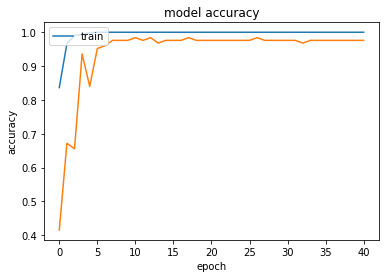

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show() 

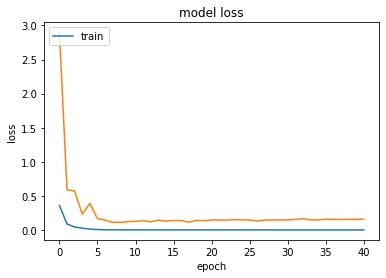

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
    model = Sequential()
    model.add(layers.Conv2D(filters=8,kernel_size=(3,3),input_shape=(256,256,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))

    model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(filters=16,kernel_size=(1,1),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
 
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))
    model.add(layers.Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2D(filters=2,kernel_size=(3,3),strides=1,padding='same'))
 
    model.add(layers.Flatten())
 
    model.add(layers.Dense(1, activation='sigmoid'))
# load weights into new model
    model.load_weights('nor_inf_28may02.h5')

In [ ]:
x_test=[]
y_test=[]

In [ ]:
for im in glob.glob('/content/chest-xray-pneumonia/chest_xray/val/NORMAL/*.*'):
  #print(im)
      img=cv2.imread(im,1)
      img=cv2.resize(img,(256,256))
      x_test.append(img)
      y_test.append(0)

In [ ]:
print(len(x_test))
print(len(y_test))

8
8


In [ ]:
for im in glob.glob('/content/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/*.*'):
  #print(im)
      img=cv2.imread(im,1)
      img=cv2.resize(img,(256,256))
      x_test.append(img)
      y_test.append(1)

In [ ]:
print(len(x_test))
print(len(y_test))

16
16


In [ ]:
for i in range(16):
    img = x_test[i]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) 
    x_test[i]=img

print('Shape of train images: ', x_test[0].shape)

Shape of train images:  (256, 256, 3)


In [ ]:
x_test=np.array(x_test)
print(x_test.shape)

(16, 256, 256, 3)


In [ ]:
y_test=np.array(y_test)

In [ ]:
from keras.utils import to_categorical
y_test_reshape = to_categorical(y_test)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
_, test_acc = model.evaluate(x_test, y_test, verbose=0)

In [ ]:
print("test accuracy: ",test_acc,)
print("test loss    : ",_)

test accuracy:  0.6875
test loss    :  1.2885456085205078


In [ ]:
y_pred=model.predict(x_test)

In [ ]:
y_pred.shape

In [ ]:
y_pred[0]
classes = np.argmax(y_pred,axis=-1)

In [ ]:
(type)(classes)
classes.shape

In [ ]:
label = []
for i in y_pred:
  if i>0.5:
    label.append(1)
  else :
    label.append(0)
print(len(label))
label = np.asarray(label)
label=label.reshape(-1,1)

16


In [ ]:
y_test=np.asarray(y_test)

In [ ]:
print(y_test[0])
print(y_pred[0])

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,label))

[[7 1]
 [4 4]]


TMC XRAY images

In [ ]:
x_samples =[]
y_samples = []

In [ ]:
for im in glob.glob('/content/drive/My Drive/covid TMC/*.*'):
  #print(im)
  img=cv2.imread(im,1)
  img=cv2.resize(img,(256,256))
  x_samples.append(img)
  y_samples.append(1)

In [ ]:
print(len(x_samples))
print(len(y_samples))

11
11


In [ ]:
for i in range(11):
    img = x_samples[i]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) 
    """img = np.power(img, gamma)""" 
    x_samples[i]=img

In [ ]:
print('Shape of sample images: ', x_samples[0].shape)

In [ ]:
x_samples=np.array(x_samples)
print(x_samples.shape)

(11, 256, 256, 3)


In [ ]:
y_samples_pred=model.predict(x_samples)

In [ ]:
sample_labels = []
for i in y_samples_pred:
  if i>0.5:
    sample_labels.append('infected')
  else :
    sample_labels.append('normal') 
print(len(sample_labels))
sample_labels = np.asarray(sample_labels)
sample_labels=sample_labels.reshape(-1,1)

11


In [ ]:
print(y_samples_pred)

[[5.4345667e-02]
 [1.4588259e-08]
 [9.9668378e-01]
 [9.9668378e-01]
 [7.4551934e-01]
 [9.9219978e-01]
 [7.6756686e-01]
 [7.1051717e-04]
 [9.6394104e-01]
 [9.9914896e-01]
 [5.9870835e-02]]


In [ ]:
print(sample_labels.shape)

In [ ]:
print(sample_labels)

[['normal']
 ['normal']
 ['infected']
 ['infected']
 ['infected']
 ['infected']
 ['infected']
 ['normal']
 ['infected']
 ['infected']
 ['normal']]
